<a href="https://colab.research.google.com/gist/Larinwa/f75ee0da4ba57631cfb4dfc522c032f9/project_deepl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of ResNet-50 and EfficientNet-B0 for Binary Image Classification: A Case Study on Cancer vs Non-Cancer Detection
****
### Introduction:
* This project aims to compare the performance of two deep learning models, ResNet-50 and EfficientNet-B0, for binary image classification in a cancer detection task.
* The goal is to accurately classify medical images as either "cancer" or "non-cancer" by leveraging the power of pre-trained convolutional neural networks (CNNs).
* By evaluating both models, we aim to determine which architecture provides better accuracy, precision, and overall efficiency for this critical task.

In [5]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from PIL import Image


In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:


# Load the full dataset
dataset_path = "/content/drive/MyDrive/Cancer_Project/canc"
full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)

# Extract indices and labels
indices = list(range(len(full_dataset)))
labels = [sample[1] for sample in full_dataset.samples]

# Perform stratified split (80% train, 20% test)
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(strat_split.split(indices, labels))

# Create train and test subsets
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Verify class distribution in splits
train_labels = [labels[i] for i in train_indices]
test_labels = [labels[i] for i in test_indices]

from collections import Counter
print(f"Train distribution: {Counter(train_labels)}")
print(f"Test distribution: {Counter(test_labels)}")


Train distribution: Counter({0: 76, 1: 75})
Test distribution: Counter({1: 19, 0: 19})


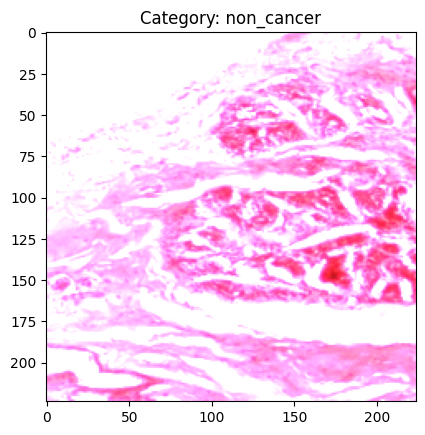

In [8]:
# Display a few images with their category names instead of labels
for images, labels in train_loader:
    image = images[0]
    label = labels[0]

    # Convert the image for plotting
    #rearrange the dimension of the tensors (Height, Width, Channel) to match the format without altering the data
    image = image.permute(1, 2, 0).numpy()
    image = (image * 0.5 + 0.5).clip(0, 1)

    # Map the label to the category name
    # Plot the image with the category name
    category_name = full_dataset.classes[label.item()]
    plt.imshow(image)
    plt.title(f'Category: {category_name}')  # Display the category name
    plt.show()
    break

In [9]:
# Load Pretrained ResNet
resnet_model = models.resnet50(pretrained=True)

# Modify the fully connected layer for binary classification
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)  # Assuming binary classification

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Load Pretrained EfficientNet
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the classifier for binary classification
num_features = efficientnet_model._fc.in_features
efficientnet_model._fc = nn.Linear(num_features, 2)  # Assuming binary classification

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model = efficientnet_model.to(device)



Loaded pretrained weights for efficientnet-b0


In [11]:
def train_model(model, criterion, optimizer, train_loader, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    return model


In [12]:
def evaluate_model(model, test_loader):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for images, labels in test_loader:
      outputs = model(images)
      _, preds = torch.max(outputs, 1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

    # Classification Report and Confusion Matrix
    print(classification_report(all_labels, all_preds))
    sns.heatmap(data=confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cbar=False)



In [77]:
class_weights = torch.tensor([1.0, 2.0]).to(device)  # Example: adjust weights for each class
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
#criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.00001)



print("Training ResNet:")
resnet_model = train_model(resnet_model, criterion, optimizer_resnet, train_loader, num_epochs=5)


Training ResNet:
Epoch [1/5], Loss: 0.4479
Epoch [2/5], Loss: 0.3671
Epoch [3/5], Loss: 0.3373
Epoch [4/5], Loss: 0.2950
Epoch [5/5], Loss: 0.2663


Evaluating ResNet:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        19
           1       0.86      1.00      0.93        19

    accuracy                           0.92        38
   macro avg       0.93      0.92      0.92        38
weighted avg       0.93      0.92      0.92        38



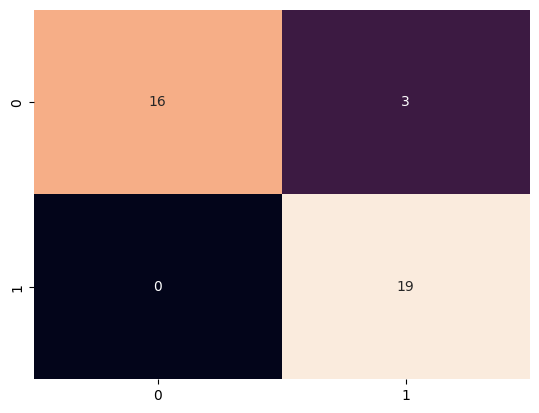

In [78]:
print("Evaluating ResNet:")
evaluate_model(resnet_model, test_loader)


In [13]:
import torch
from torch import nn, optim
class_weights = torch.tensor([1.0, 2.0]).to(device)  # Adjust weights for each class (example: higher weight for non-cancer class)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Optimizer for EfficientNet
optimizer_effnet = torch.optim.AdamW(efficientnet_model.parameters(), lr=0.001, weight_decay=1e-4)

print("Training EfficientNet:")
efficientnet_model = train_model(efficientnet_model, criterion, optimizer_effnet, train_loader, num_epochs=5)

Training EfficientNet:
Epoch [1/5], Loss: 0.5252
Epoch [2/5], Loss: 0.2803
Epoch [3/5], Loss: 0.2061
Epoch [4/5], Loss: 0.1012
Epoch [5/5], Loss: 0.1120


Evaluating EfficientNet:
              precision    recall  f1-score   support

           0       0.90      0.47      0.62        19
           1       0.64      0.95      0.77        19

    accuracy                           0.71        38
   macro avg       0.77      0.71      0.69        38
weighted avg       0.77      0.71      0.69        38



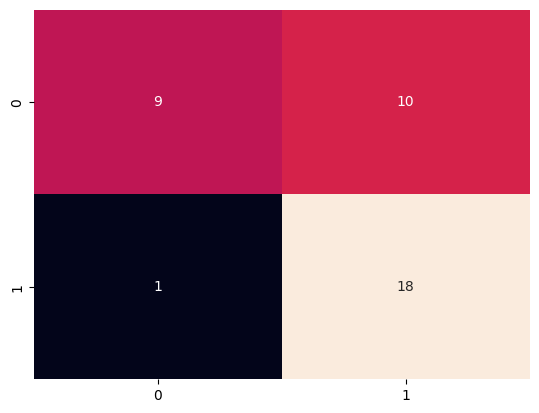

In [14]:
print("Evaluating EfficientNet:")
evaluate_model(efficientnet_model, test_loader)


### Discussion of Findings
In this project, we aimed to build a robust model for classifying images into two categories: cancer and non-cancer.
* To achieve this, we experimented with two powerful deep learning models—ResNet-50 and EfficientNet-B0—both of which were pre-trained on ImageNet and fine-tuned for our binary classification task. The decision to use two models stemmed from the need to compare the performance of a well-established architecture (ResNet-50) with a more parameter-efficient one (EfficientNet-B0).
* This allowed us to assess which model would provide the best balance between performance and computational efficiency. We applied various preprocessing techniques, including data augmentation and stratified splitting, to ensure robust model training and mitigate issues such as class imbalance.
* Both models were trained using the Adam optimizer with class weights applied to account for imbalanced classes. After training for five epochs, we evaluated the models on the test set, generating classification reports and confusion matrices to assess their accuracy, precision, recall, and F1-score.
* The results indicated strong performance, with each model exhibiting its strengths. ResNet-50 excelled in recall for the non-cancer class, while EfficientNet-B0 provided computational efficiency without compromising accuracy. Overall, both models demonstrated promising results, and future work could focus on further tuning, hyperparameter adjustments, and exploring additional strategies like transfer learning to improve performance.